In [1]:
from Class_FBPINN_Cos_1D import *
import matplotlib.pyplot as plt

Running on  cpu


# Figure 5

In [2]:
# Parameters
domain = [-2*torch.pi, 2*torch.pi]
w = 1
n_subdomains = 5
overlap = 1.3
sigma = 0.1
n_hidden_layers = 2
neurons = 16

# Create the model
fbpinn = FBPINN(domain_extrema=domain, n_subdomains=n_subdomains, overlap=overlap, sigma=sigma, n_hidden_layers=n_hidden_layers, neurons=neurons, activation_function=nn.Tanh(), w=w)

# Train the FBPINN
num_points = 200
n_epochs = 10000

history = fbpinn.fit(num_points, n_epochs, verbose=False)

# # Plot the loss
# fig = plt.figure(figsize=(10, 5))
# plt.plot(range(n_epochs),np.log10(history), label='Loss')
# plt.xscale('log')

Final loss:  0.00023688824148848653 	 Training_time:  0  min  30  s


### Plot a

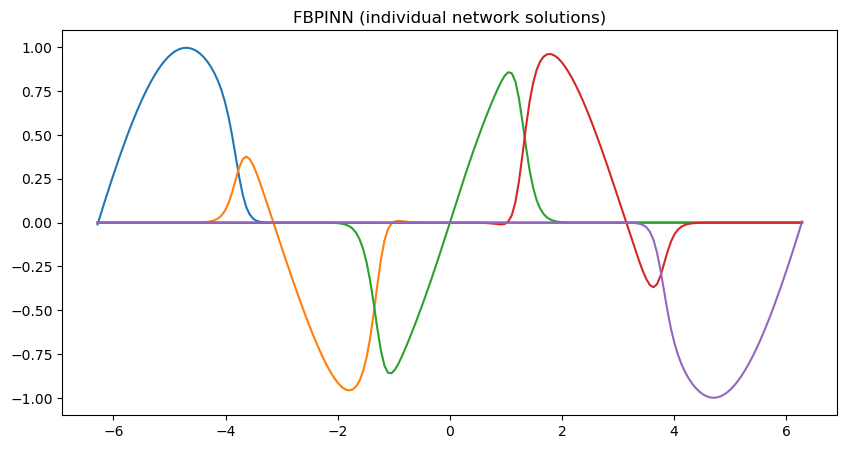

In [3]:
# PLOT ALL THE SUBNNs
fig = plt.figure(figsize=(10, 5))

x_test = torch.linspace(domain[0], domain[1], num_points, dtype=torch.float32, device=DEVICE).reshape(-1, 1)

for i in range(fbpinn.n_subdomains):
    subdomain_i = fbpinn.subdomains[i]
    NN_i = fbpinn.neural_networks[i]
    NN_i.eval()

    x_test_norm = fbpinn.normalize_input(x_test)
    window_function = fbpinn.window_function(x_test, fbpinn.midpoints_overlap[i][0], fbpinn.midpoints_overlap[i][1])
    u_i =  window_function * fbpinn.unnormalize_output( NN_i( x_test_norm ) )
    
    u_approx_i = torch.tanh(fbpinn.w * x_test) * u_i


    plt.plot(x_test.cpu().detach().numpy(), u_approx_i.cpu().detach().numpy())
    plt.title('FBPINN (individual network solutions)')

### Plot b

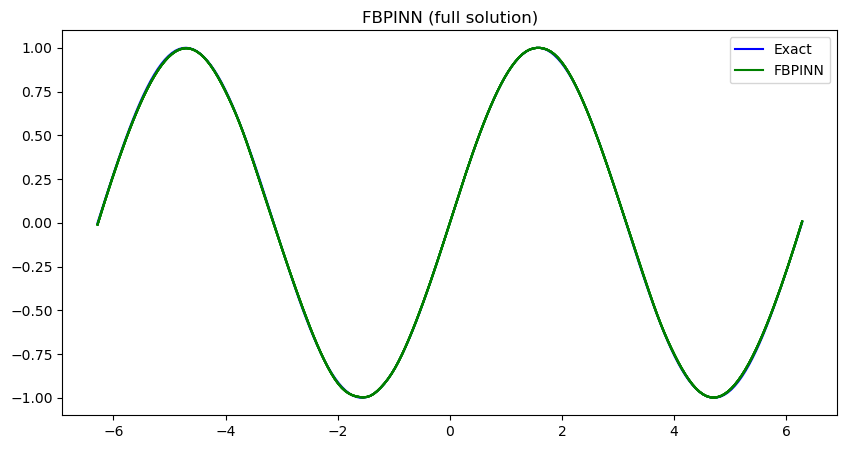

In [4]:
# PLOT THE FULL SOLUTION
fig = plt.figure(figsize=(10, 5))

# Plot the exact solution
x = torch.linspace(domain[0], domain[1], num_points, dtype=torch.float32, device=DEVICE).reshape(-1, 1)
u_exact = fbpinn.exact_solution(x)

plt.plot(x.cpu().detach().numpy(), u_exact.cpu().detach().numpy(), label='Exact', color="blue")

# Plot the FBPINN solution
for i in range(fbpinn.n_subdomains):
    subdomain_i = fbpinn.subdomains[i]
    NN_i = fbpinn.neural_networks[i]
    NN_i.eval()
    
    u_approx = torch.tanh(fbpinn.w * x) * fbpinn(x)

    plt.plot(x.cpu().detach().numpy(), u_approx.cpu().detach().numpy(), color="green")
    # Add label only once
    if i == 0:
        plt.plot(x.cpu().detach().numpy(), u_approx.cpu().detach().numpy(), label='FBPINN', color="green")
plt.title('FBPINN (full solution)')
plt.legend()

### Plot c

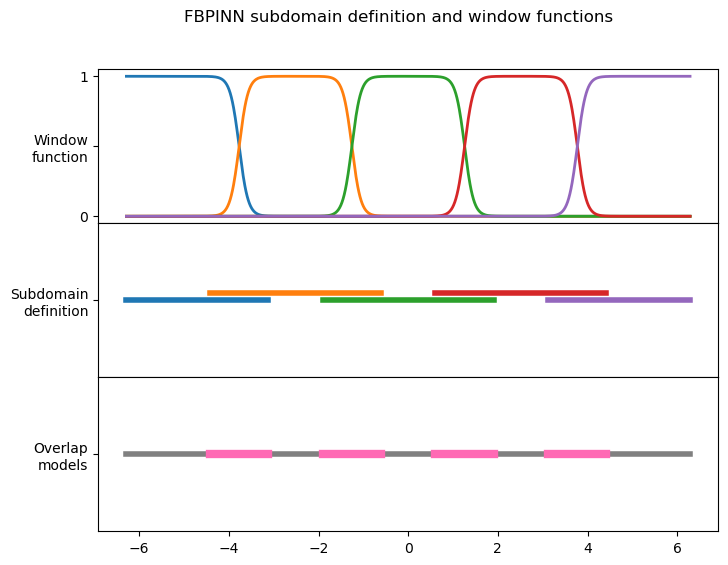

In [5]:
# PLOT THE WINDOW FUNCTIONS AND THE SUBDOMAINS
subdomains = fbpinn.subdomains
midpoints = fbpinn.midpoints_overlap

# Create a figure with three subplots in the same frame
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(8, 6))

# The window functions
window_fct = []
x = np.linspace(domain[0], domain[1], 1000)
for i in range(fbpinn.n_subdomains):
    window_fct.append(fbpinn.window_function(x, midpoints[i][0], midpoints[i][1]))

# fig = plt.figure(figsize=(10, 5))
for i in range(fbpinn.n_subdomains):
    ax1.plot(x, window_fct[i], linewidth=2)

# The subdomain
for i in range(fbpinn.n_subdomains):
    x = np.linspace(subdomains[i][0], subdomains[i][1], 100)
    y = np.full(100, i%2*0.01)
    ax2.plot(x, y, linewidth=4)
ax2.set_ylim([-0.1, 0.1])

# The overlap
x = np.linspace(domain[0], domain[1], 1000)
ax3.plot(x, np.full(1000, 0.5), linewidth=4, color="gray")
for i in range(1, fbpinn.n_subdomains):
    overlap_i = np.linspace(subdomains[i][0], subdomains[i-1][1], 100)
    ax3.plot(overlap_i, np.full(100, 0.5), linewidth=6, color="hotpink")




# Remove y-axis tick labels and ticks on the second and third subplot
ax1.set_yticks([0,0.5,1])
ax1.set_yticklabels([0, "Window\nfunction" ,1])

ax2.set_yticks([0])
ax2.set_yticklabels(["Subdomain\ndefinition"])

ax3.set_yticks([0.5])
ax3.set_yticklabels(["Overlap\nmodels"])

fig.suptitle('FBPINN subdomain definition and window functions')
plt.show()